

# Statistics
## Yoav Ram

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import scipy.special as spec
import statsmodels.api as sm
from statsmodels.formula.api import ols
import urllib.request
import os.path
import zipfile
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
np.random.seed(847)

/Users/noa/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Some of the presented exercises follow the book [IPython Cookbook](http://ipython-books.github.io/cookbook/) by [Cyrille Rossant](http://cyrille.rossant.net/).

# Hypothesis testing recap


Given a bunch of observations, we might want to test a certain assumption about the population, named null hypothesis ($H_0$) against an *alternative hypothesis* ($H_1$). 

Steps:
1. State a null and alternative hypothesis.
2. Define a test statistic- which is a quantity estimated from the data (with a known disrtibution assuming $H_0$).
3. Choose the level of significance  (typically 0.05)
4. Perform the experiment and calculate the test statistic. Employ the PDF (probability density function) for continuous variables or PMF (probability mass function) for discrete variables to determine if the probability of obtaining the test statistic or a more extreme value (referred to as a p-value) falls below the specified significance level. If it does, reject the null hypothesis in favor of the alternative hypothesis.


## **Coin flip example:** 

Imagine tossing a coin with an unknown probability `p` of landing on heads (and repeating it `n` times).
Based on the observations, we might want to test if the coin is fair (i.e., `p`=0.5).

1. $H_0: p = 0.5 $ ;  $H_1: p \ne 0.5$
2. The test statistic is the total count of heads (`x`) out of the `n` tosses. Assuming $H_0$, `x` is distribution as a binomial random variable!
3. Let's choose a significance level of 0.05.

### Binomial random variable recap
A binomial random variable represents the number of successes (usually denoted as `x`) in a fixed number of independent and identical experiments (`n`), each with only two possible outcomes: success or failure. The probability of success is usually denoted by `p` . 
Hence, the distribution of a binomial random variable is defined by two parameters, `n` and `p`.
The PMF gives the probability of obtaining a specific number of successes (`k`) in a fixed number of independent and identical experiments.

The formula for the PMF of a binomial random variable is:

![formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/b872c2c7bfaa26b16e8a82beaf72061b48daaf8e)
![nk](https://wikimedia.org/api/rest_v1/media/math/render/svg/d33401621fb832dd2f9783e80a906d562f669008)

Of course that possible values of `k` range from 0 to `n`.


Let's write a function that flips a coin `n` times and returns the number of times it landed on *head*. It's a special coin - the probability that it falls on *head* is `p`:






In [2]:
def flip(n, p):
    #np.random.seed(3)
    randoms = np.random.random(n) #Generate n random uniform numbers over the interval [0.0, 1.0)
    heads = randoms < p # Create a boolean array
    return heads.sum()

Let's use this function:

In [3]:
n = 100
p = 0.56
x = flip(n, p=p)
x

61

## One sample mean hypothesis tests

As already mentioned, `x` is our test statistic, which is distributed as a binomial random variable according to `H0`. So we create a binomial random variable according to our null hypothesis (i.e., assuming $ p = 0.5 $ ), and we calculate the probability to get the result `x` or anything **more extreme** using the PMF under `H0`. 

In [4]:
p0 = 0.5
H0 = scipy.stats.binom(n, p0) # binomial random variable under the null hypothesis

Let's create a plot for the Probability Mass Function (PMF) of the random variable under the null hypothesis using the pmf function from the scipy library:

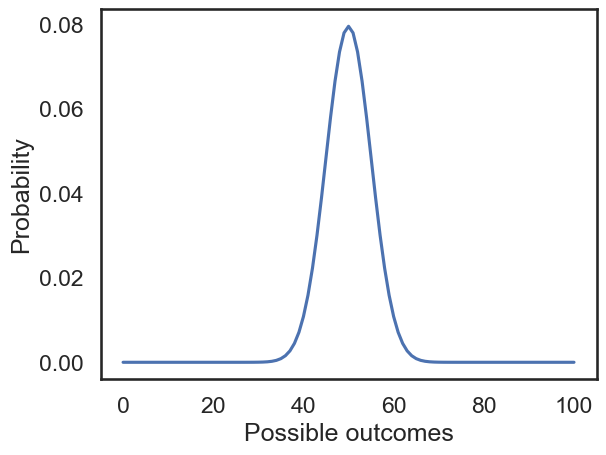

In [5]:
k = np.arange(0, n+1) # numbers from 0 to n
plt.plot(k, H0.pmf(k))
plt.xlabel('Possible outcomes')
plt.ylabel('Probability');

## Exercise 1

Generate a [geometric random variable](https://en.wikipedia.org/wiki/Geometric_distribution) using the `scipy.stats.geom` function with $ p = 0.1 $.Note that a geometric random variable is a discrete random varialbe with possible values of (1,+inf).Plot its PMF for values of 1 to 100.

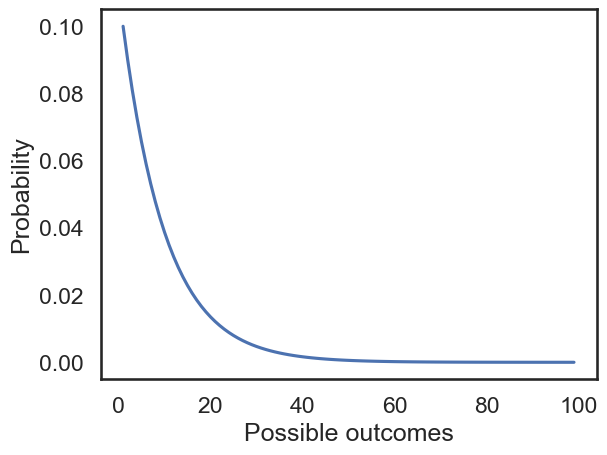

In [9]:
gr = scipy.stats.geom(0.1)
k = np.arange(1, 100) # numbers from 0 to n
plt.plot(k, gr.pmf(k))
plt.xlabel('Possible outcomes')
plt.ylabel('Probability');


Let's enhance our previous visual representation. We'll include our observed count (`x`) in the plot and examine the question- how extreme is our observation under the null hypothesis $H_0$ 

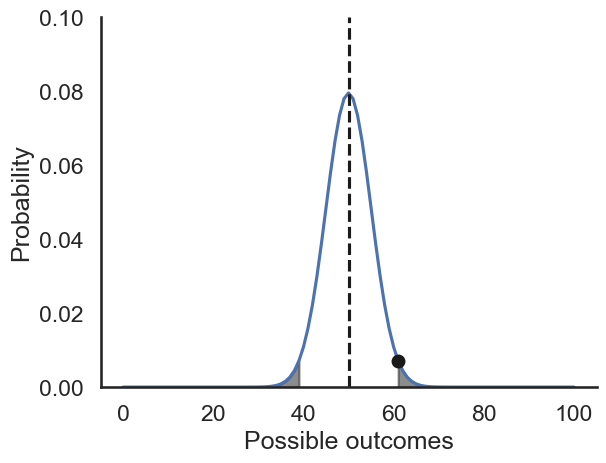

In [6]:

k = np.arange(0, n+1) # numbers from 0 to n

# plot probability of each possible result if null hypothesis is true
plt.plot(k, H0.pmf(k)) 
# Add a black circular marker to indicate the probability associated with our observation (x) if null hypothesis is true
plt.plot(x, H0.pmf(x), 'ok') # 'ok'-> black circular marker
# Adding a dashed line indicating the outcome with highest probability if null hypothesis is true
plt.axvline(n*p0, ls='--', color='k') 
# fill area of results as or less likely then observation
plt.fill_between(k[k>=x], H0.pmf(k[k>=x]), color='k', alpha=0.5)
plt.fill_between(k[k<=n*p0-(x-n*p0)], H0.pmf(k[k<=n*p0-(x-n*p0)]), color='k', alpha=0.5)

plt.ylim(1e-27, 1e-1)
#plt.yscale('log') #A logarithmic scale is applied solely for visualization purposes. To view the data in its original scale, you can comment out this line of code.
plt.xlabel('Possible outcomes')
plt.ylabel('Probability')
sns.despine()

Now let's calculate the p-value manually:

In [7]:
# probability of results as or less likely then observation
low_tail = H0.pmf(k[k<=n*p0-(x-n*p0)]) 
high_tail = H0.pmf(k[k>=x])
# sum of these results is the p-value
#p-value = probability to get this observation or worse if null hypothesis is true
pvalue = low_tail.sum() + high_tail.sum()
print(f'pvalue = {pvalue}')

pvalue = 0.03520020021770479


Instead of doing the p-value calculation yourself, you can use scipy.stats.binom_test. This handy function in the SciPy library tests whether the probability of success in a Bernoulli experiment equals a specified probability (q0).

In [8]:
pval = scipy.stats.binom_test(x, n=n, p=p0)
print("P-value: {0:.2g}, Reject null hypothesis: {1}".format(pval, pval < 0.05))

P-value: 0.035, Reject null hypothesis: True


# T-test, Correlation-test, Anova and basic linear regression model 


We will use the *Iris dataset*, which consists of measurements from 150 iris flowers, **representing three different species** : setosa, versicolor, and virginica.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Iris_germanica_%28Purple_bearded_Iris%29%2C_Wakehurst_Place%2C_UK_-_Diliff.jpg/440px-Iris_germanica_%28Purple_bearded_Iris%29%2C_Wakehurst_Place%2C_UK_-_Diliff.jpg" width="200"/>


In [68]:
filename = '../data/iris_original.csv'
iris_data = pd.read_csv(filename)
iris_data.head()

,petal_length,petal_width,sepal_length,sepal_width,species
0,1.4,0.2,5.1,3.5,setosa
1,1.4,0.2,4.9,3.0,setosa
2,1.3,0.2,4.7,3.2,setosa
3,1.5,0.2,4.6,3.1,setosa
4,1.4,0.2,5.0,3.6,setosa


## Correlation tests 

<img src="https://files.realpython.com/media/py-corr-1.d13ed60a9b91.png" width="500"/>

Correlation tests are statistical methods used to assess the strength and direction of the relationship between two or more variables. These tests help to determine if there is a statistically significant association between the variables. Two common types of correlation tests include:

[*Pearson's linear correlation*](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)  (Pearson's r): Measures the linear relationship between two continuous variables. It ranges from -1 to 1, where -1 indicates a perfect negative correlation, 1 indicates a perfect positive correlation, and 0 indicates no linear correlation.

[*Spearman Rank Correlation Coefficient*](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) (Spearman's rho): Assesses the monotonic relationship (whether the variables tend to increase or decrease together, but not necessarily at a constant rate) between two variables. It is less sensitive to outliers than Pearson's correlation.



Let's make a plot showing how petal length relates to petal width.

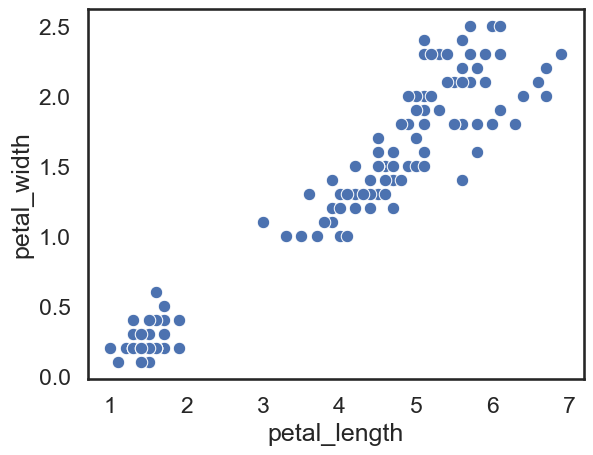

In [4]:

sns.scatterplot(x="petal_length",
                    y="petal_width",
                    #hue="species",
                    data=iris_data);


Looking at the plot, we can see that petal width and petal length are positively correlated!

Let's compute both the Pearson's and Spearman's correlation coefficients, along with their respective p-values, for the relationship between petal length and petal width.


In [5]:
pearson_r, pearson_pval = scipy.stats.pearsonr(iris_data['petal_length'],iris_data['petal_width'])
print(f"Pearson: r = {pearson_r}, p-value = {pearson_pval}")
spearman_r, spearman_pval = scipy.stats.spearmanr(iris_data['petal_length'],iris_data['petal_width'])
print(f"Spearman: r = {spearman_r}, p-value = {spearman_pval}")
# default method is "pearson"

Pearson: r = 0.962865431402796, p-value = 4.6750039073285846e-86
Spearman: r = 0.9376668235763412, p-value = 8.156596854126675e-70


A strong positive connection is suggested by a correlation coefficient of 0.96 / 0.93. 

Now let's generate a pairwise correlation matrix among all the numerical columns.

In [8]:
cormat = iris_data[["sepal_width","sepal_length","petal_width","petal_length"]].corr()
print(cormat)

              sepal_width  sepal_length  petal_width  petal_length
sepal_width      1.000000     -0.117570    -0.366126     -0.428440
sepal_length    -0.117570      1.000000     0.817941      0.871754
petal_width     -0.366126      0.817941     1.000000      0.962865
petal_length    -0.428440      0.871754     0.962865      1.000000


We can also generate a heatmap visualizations:

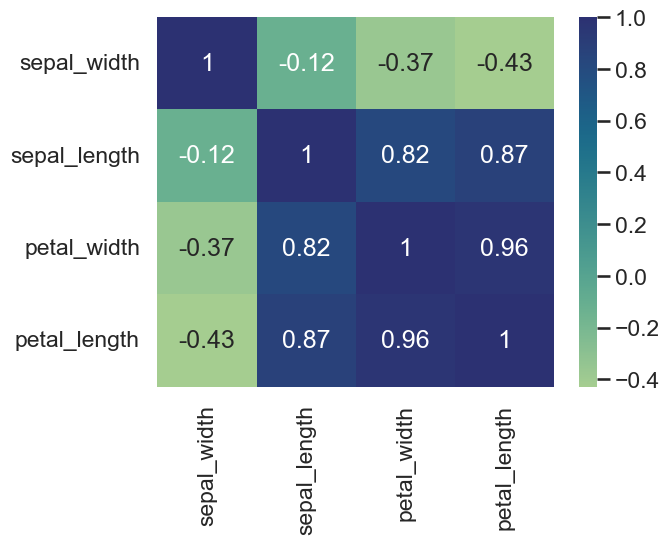

In [9]:
sns.heatmap(cormat,annot = True,cmap="crest");


We can deduce that there is a strong positive correlation between petal length and petal width, a moderate positive correlation between sepal length and both petal length and petal width, and a relatively low negative correlation between sepal width and the other variables.

## One sample t-test

A one-sample t-test is a statistical method used to determine whether the mean of a single sample is significantly different from a known or hypothesized population mean. 

Assumption: observations are normally distributed.

Here, we aim to assess the hypothesis that the actual mean petal width of the Setosa iris flowers population is 2.5. 

1. $H_0: \mu = 2.5 $ ;  $H_1: \mu \ne 2.5$ 
2. The test statistic is $ {\displaystyle t={\frac {Z}{s}}={\frac {{\bar {X}}-\mu }{{\hat {\sigma }}/{\sqrt {n-1}}}},
} $.  
According to the null hypothesis, the t statistic follows a [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with n-1 degrees of freedom, where n is the number of samples. 
3. Let's choose a significance level of 0.05.



We can use the `scipy.ttest_1samp` function for a straightforward approach to hypothesis testing, as it computes the t-statistic and p-value automatically. 

In [42]:
sample_petal_width_setosa = (iris_data.loc[iris_data.species=='setosa']['petal_width'])
mu0 = 2.5
ttest_one_sample_result = scipy.stats.ttest_1samp(sample_petal_width_setosa,mu0)
print(ttest_one_sample_result)

Ttest_1sampResult(statistic=-151.23687158467052, pvalue=4.353916120153066e-67)


Alternatively, we have the option to manually estimate these values using the provided formula and the `scipy.stats.t.sf` function

In [41]:
n = len(sample_petal_width_setosa.index)
manual_t_statistic = (np.mean(sample_petal_width_setosa)-mu0)/(np.std(sample_petal_width_setosa)/np.sqrt(n-1))
pval = 2 * (scipy.stats.t.sf(np.abs(manual_t_statistic), n - 1))
print(f'Manual t statistic = {manual_t_statistic} p value = {pval} ')

Manual t statistic = -151.23687158467047 p value = 4.353916120153066e-67 


## Two sample t-test

A two-sample t-test is a statistical method used to compare the means of two independent groups to determine if there is a significant difference between them. 
Assumptions:
1. Data in each group are normally distributed.
2. The variances for the two groups are equal.

Here, we aim to determine whether the mean of sepal width across the versicolor species is significantly different from the mean of sepal width across the virginica species.

1. $H_0: \mu_1  = \mu_2  $ ;  $H_1: \mu_1 \ne \mu_2$ 

2. The test statistic is ${\displaystyle t={\frac {{\bar {X}}_{1}-{\bar {X}}_{2}}{s_{p}\cdot {\sqrt {{\frac {1}{n_{1}}}+{\frac {1}{n_{2}}}}}}}. }$
According to the null hypothesis, the t statistic follows a [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with $n_1+n_2-2$ degrees of freedom, where n is the number of samples.  ${\displaystyle s_{p}={\sqrt {\frac {(n_{1}-1)s_{X_{1}}^{2}+(n_{2}-1)s_{X_{2}}^{2}}{n_{1}+n_{2}-2}}}}$

3. Let's choose a significance level of 0.05.

We will use the `scipy.stats.ttest_rel` function for a straightforward approach to hypothesis testing, as it computes the t-statistic and p-value automatically.


In [50]:
versicolor_sepal_width = iris_data.loc[iris_data.species=='versicolor']['sepal_width'] 
virginica_sepal_width = iris_data.loc[iris_data.species=='virginica']['sepal_width'] 
scipy.stats.ttest_rel(versicolor_sepal_width,virginica_sepal_width)

Ttest_relResult(statistic=-3.075529836656036, pvalue=0.0034322095632924993)





## Anova


[**ANOVA**](https://en.wikipedia.org/wiki/Analysis_of_variance), or Analysis of Variance, is a statistical test used to analyze the differences among group means in a sample. It assesses whether there are any statistically significant differences between the means of three or more independent (unrelated) groups.

Note that the One-Way Anova is an extension of the two sample t-test for more than two groups.

(1 )*Normality assumption*: The model residuals (the differences between observed and predicted values) should be approximately normally distributed. This assumption is more critical with smaller sample sizes.

(2) *Homogeneity of Variances (Homoscedasticity)*: The variances of the different groups should be approximately equal. 

Note that if we reject the null hypothesis, it doesn't indicate which particular group or groups differ from the others. To identify these differences, a post-hoc analysis is required.

Here, we want to see if the petal lengths of Setosa, Versicolor, and Virginica species are significantly different. To start, we'll use a boxplot to show how the sepal widths are spread in each group.


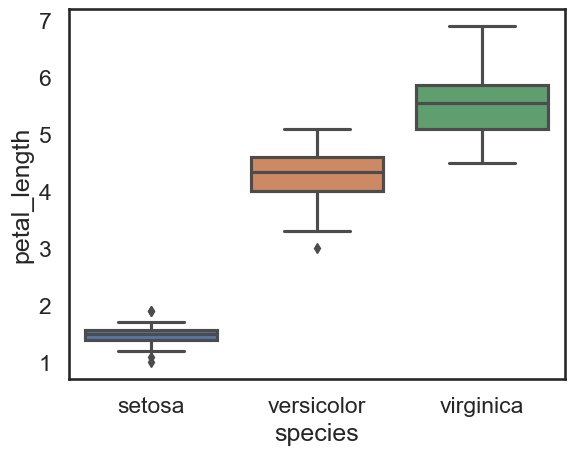

In [24]:
sns.boxplot(data=iris_data, x="species", y="petal_length");

The petals length vary quite a bit between different species. Let's see if the petal lengths means among the three species are *significantly* different using the ANOVA test.

In [54]:
model = ols('petal_length ~ C(species)', data=iris_data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(species),437.1028,2.0,1180.161182,2.856777e-91
Residual,27.2226,147.0,NaN,NaN


To test the model's first assumption (normality of model's residuals), let's use  [QQ-plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot), which is a graphical tool used in statistics to assess whether a dataset follows a particular theoretical distribution. Here we use it for the normal distribution in our case.

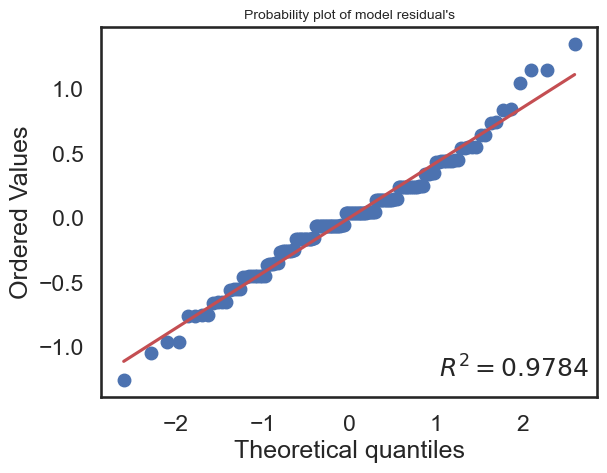

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)

normality_plot, stat = scipy.stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 10);

In an ideal scenario, where the model's residuals perfectly follows the normal distribution, the Q-Q plot would form a straight line. Here, the points in the Q-Q plot do not closely follow the reference.

We can also use the [**Shapiro test for normality**](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) to test the null hypothesis that the residuals are normally distributed.

In [59]:
print(scipy.stats.shapiro(model.resid))

ShapiroResult(statistic=0.9810755252838135, pvalue=0.03676711767911911)


Both the QQ-plot and the Shapiro test indicate the model's residuals are *not normally distributed*. As a result, we should use a non-parametric test.
The [**Kruskal-Wallis H-test**](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) is a *non-parametric* alternative to Anova. It tests the null hypothesis that the medians of different groups are the same. It's like a non-parametric version of ANOVA and works with two or more independent samples, even if their sizes are different. 

## Exercise 2
Use the Kruskal-Wallis implementation in `scipy.stats` and apply it as a non-parametric replacement for ANOVA to test the null hypothesis that the medians of the Setosa, Versicolor, and Virginica species are the same. Print the H statistic and the corresponding p-value.

In [60]:
#Your code here

kruskal F-statistic: 63.571146104163795, p-value 1.5692820940316782e-14


## Linear regerssion


Linear regression model asseses the relationship between a dependent variable and one or more explantory variables by fitting a linear equation to the observed data.

#### Simple linear regression model:

We assume the model: $ y=\alpha +\beta x$, where $\alpha$ is the model's slope and $\beta$ is the mode's intrercept. 

Given n observed data pairs ($x_i,y_i$), we assume that $y_i=\alpha +\beta x_i+\epsilon_i$, where $\epsilon_i$ is an error term. The goal is to find estimated values $\hat{\alpha} , \hat{\beta}$, which provide the best fit to the observed data.
What is the best fit?
The best fit is defined as the one that minimizes the sum of squared residuals (differences between predicted vs. observed values of the dependent variable). 

${\displaystyle ({\hat {\alpha }},\,{\hat {\beta }})=\operatorname {argmin} \left(Q(\alpha ,\beta )\right),}$ 

${\displaystyle Q(\alpha ,\beta )=\sum _{i=1}^{n}{\widehat {\varepsilon }}_{i}^{\,2}=\sum _{i=1}^{n}(y_{i}-\alpha -\beta x_{i})^{2}\ .}$

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Linear_least_squares_example2.svg/440px-Linear_least_squares_example2.svg.png" width="200"/>

#### Multivariate linear regression model:

We assume a richer model: $ y=\alpha +\beta_1 x_1 +\beta_2 x_2+.. +\beta_p x_p$

Here we have *p* independent variables.

### Main assumptions:

(1) The model's residuals (the differences between the observed and predicted values) are normally distributed. 

(2) Homoscedasticity: Homoscedasticity assumes that the variance of the errors (residuals) is constant across all levels of the independent variable(s). In other words, the spread of the residuals should be roughly the same for all values of the independent variable(s). 


Here, we aim to be able to predict the sepal width based on the other plant characteristics: sepal length, petal width and petal length.
Let's start by plotting the relationship between sepal length and sepal width.

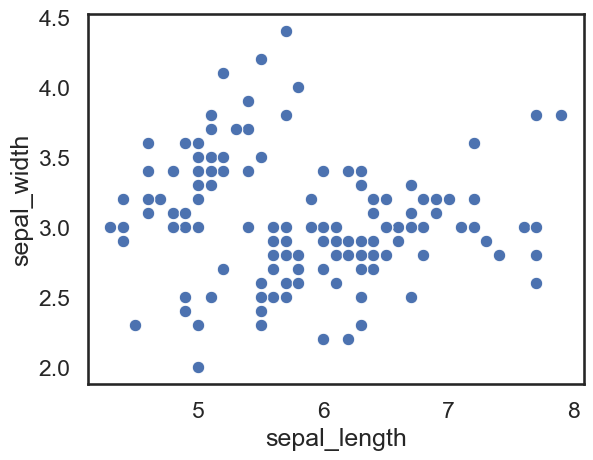

In [50]:
sns.scatterplot(x="sepal_length",
                    y="sepal_width",
                    #hue="species",
                    data=iris_data);

There isn't a clear linear relationship. 
Let's define a linear model in which the dependent variable is the sepal length and the explanatory variable is sepal width. 

In [42]:
model_0 = ols(formula="sepal_width ~ sepal_length", data=iris_data).fit()



Let's obtain the model estimates of intercept and slope:


In [43]:
intercept, slope = model_0.params
print(f"Inferred intercept  = {round(intercept,2)}, Inferred slope  = {round(slope,2)} ")

Inferred intercept  = 3.42, Inferred slope  = -0.06 


### Ex3:

a. Using the intercept and slope, generate a vector of the model's predictions. 

b. Plot the regression line (model's predicted dependent variable, sepal length, vs. the independent variable- sepal length) on top of the scatter plot of sepal_length vs. sepal_width.

''

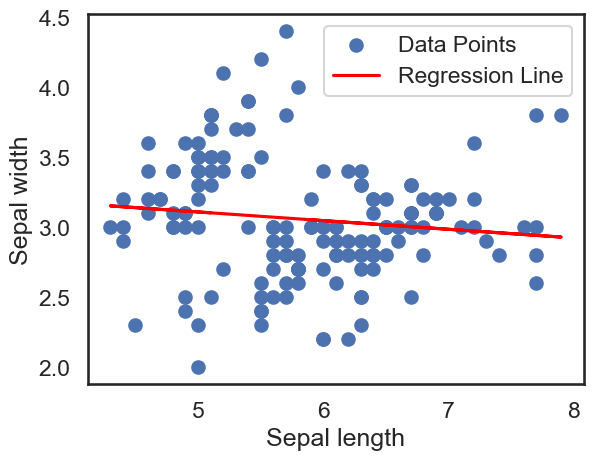

In [48]:
### a

predicted_sepal_width = intercept + slope * iris_data['sepal_length'] 

### b

# Create a scatter plot of the data points
plt.scatter(iris_data['sepal_length'], iris_data['sepal_width'], label='Data Points')

# Plot the regression line on top of it
plt.plot(iris_data['sepal_length'], predicted_sepal_width , color='red', label='Regression Line')

# Add labels and a legend
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.legend()
;

The regression line seems very noisy. We can obtain a summary of the regression perfrmamcne, in a similar manner as in the R language:

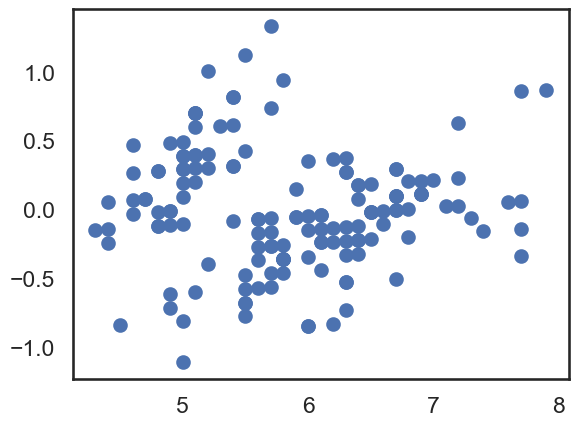

In [54]:
plt.scatter((iris_data["sepal_length"]),model_0.resid); #model_0.predict

In [49]:
model_0.summary() #print a summary of model performance

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sepal_width   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.074
Date:                Tue, 09 Jan 2024   Prob (F-statistic):              0.152
Time:                        16:56:03   Log-Likelihood:                -86.732
No. Observations:                 150   AIC:                             177.5
Df Residuals:                     148   BIC:                             183.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.4189      0.254     13.484      0.000       2.918       3.920
sepal_length    -0.0619      0.043     -1.440      0.152      -0.147       0.023
==============================================================================
Omnibus:                        2.474   Durbin-Watson:                   1.263
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.994
Skew:                           0.243   Prob(JB):                        0.369
Kurtosis:                       3.288   Cond. No.                         43.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model obtained a very small R^2, and the sepal length variable is not statistically significant. Currently, the model's performance is very poor. Let's try to enrich the model.

Let's visualize the relationhip between sepal width and sepal length **within** each species.

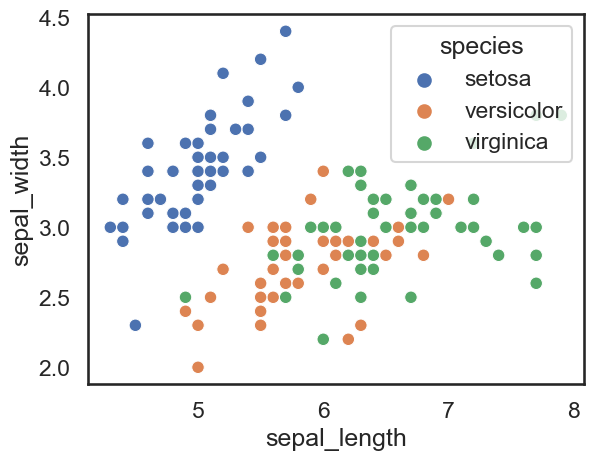

In [55]:
sns.scatterplot(x="sepal_length",
                    y="sepal_width",
                    hue="species",
                    data=iris_data);

Interestingly, we can see that **within** each species there is a linear relationship between sepal length and sepal width!
Let's generate a new model that includes the species as a categorical variable.

In [34]:

model_1 = ols(formula="sepal_width ~ sepal_length+C(species)", data=iris_data).fit()
(model_1.summary()) #print a summary of model performance

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sepal_width   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     64.32
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           1.46e-26
Time:                        16:47:08   Log-Likelihood:                -24.609
No. Observations:                 150   AIC:                             57.22
Df Residuals:                     146   BIC:                             69.26
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    1.6765      0.235      7.123      0.000       1.211       2.142
C(species)[T.versicolor]    -0.9834      0.072    -13.644      0.000      -1.126      -0.841
C(species)[T.virginica]     -1.0075      0.093    -10.798      0.000      -1.192      -0.823
sepal_length                 0.3499      0.046      7.557      0.000       0.258       0.441
==============================================================================
Omnibus:                        3.680   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                3.253
Skew:                          -0.269   Prob(JB):                        0.197
Kurtosis:                       3.481   Cond. No.                         64.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we obtained a relatively high R^2, and both the sepal width and species obtained very small p-values, indicating they should be included in the model!

Now let's also add petal length and petal width to the model, and see if we improve the R^2.

In [35]:
model_2 = ols(formula="sepal_width ~ sepal_length+C(species)+petal_length+petal_width", data=iris_data).fit()
#predictions = model.predict(X) 
print(f'R^2 = {np.round(model_2.rsquared,2)}') #print a summary of model performance

R^2 = 0.64


The R^2 improved, again! However, to test if the addition of these variables to the model is *significant*, we should use an [**F test**](https://en.wikipedia.org/wiki/F-test).

In [60]:
F_statistic, p_value, df = (model_2.compare_f_test(model_1))
print(f"F statistic = {round(F_statistic,2)}, p-value= {p_value}, degrees of freedom = {df}")

F statistic = 13.01, p-value= 6.416048801411127e-06, degrees of freedom = 2.0


We obtained a sifnificant result, indicating that the richer model (which includes the new variables) is better.
 
Note that obtaining higher R^2 does not necessarily indicate a better model.

**Ex2**: As an experiment, try to add 50 *random variables* to the model and see if R^2 improves.

In [78]:
iris_data_cp = iris_data.copy()

random_matrix_df = pd.DataFrame(np.random.rand(len(iris_data_cp.index),100))
random_matrix_df.columns = [f'test_{i}' for i in range(100)]
iris_data_cp = pd.concat([iris_data_cp,random_matrix_df],axis=1)
all_columns = "+".join(iris_data_cp.drop(columns=['sepal_width']).columns)
model_3 = ols(formula=f"sepal_width ~ {all_columns}", data=iris_data_cp).fit()
print(f'R^2 = {np.round(model_3.rsquared,2)}')
#print(model_3.summary())

R^2 = 0.88


It turns out that even when adding non-relevant variables to the model it can only **increase** (and not decrease) the R^2!
This phenomenon is known as model **overfitting**. It basically means that our model has too many degrees of freedom,enabling it to fit the noise as well!  
The consequence of overfitting is that predictions on new data, coming from the same distribution, will be poor.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*6vPGzBNppqMHllg1o_se8Q.png" width="800"/>

Hence, we should not use R^2 on our training data as a metric to choose between models, as it leads to overfitting.
What metric should we used instead for linear regressiob models?

* In case of nested models (such as model_1 and model_2), we can use an F-test (as we did in previous section). 
* For non-nested models we can use [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) or [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion), which penalize models for high number of parameters. A lower AIC or BIC value indicates a better fit!
For example, using the AIC criterion on the models we created

In [82]:
print(f"model 0 AIC = {round(model_0.aic,2)}")
print(f"model 1 AIC = {round(model_1.aic,2)}")
print(f"model 2 AIC = {round(model_2.aic,2)}")
print(f"model 3 AIC = {round(model_3.aic,2)}")

model 0 AIC = 177.46
model 1 AIC = 57.22
model 2 AIC = 36.31
model 3 AIC = 72.65


We can see that model 2 is the best model based on the AIC criterion.

## Training and Test data sets
A more comprehensive approach to model selection and assessing model performance involves utilizing an independent dataset known as a **test set**. This test set is distinct from the training data and is not used during the model training process. It serves as an estimate of how well our model performs on new, unseen data.
Rather than assessing the model's performance on the data used for training, i.e., the training set, we evaluate it on the test set.  
*We will employ this methodology next week to estimate the performance of our models*.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Traintest.svg/1400px-Traintest.svg.png" width="800"/>

# References

- [IPython Cookbook](http://ipython-books.github.io/cookbook/): IPython Interactive Computing and Visualization Cookbook by Cyrille Rossant.
- [scipy.stats tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html)
- [Scipy's statistical functions](http://docs.scipy.org/doc/scipy/reference/stats.html)
- [Visualizing distributions in Seaborn](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html)
- [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) on Wikipedia

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.7.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)